<a href="https://colab.research.google.com/github/1000century/Baekjoon/blob/main/augmentation_setting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
## settings
sample_num_setting = 500
epoch_setting = 2
label_smoothing_setting = 0.15
learning_rate_setting = 3e-3
train_batch_setting, valid_batch_setting, test_batch_setting = 16,32,64
fold_num_setting = 1

experiment_setting = {
    'sample_num_setting':sample_num_setting,
	'epoch_setting': epoch_setting,
 'label_smoothing_setting': label_smoothing_setting,
 'learning_rate_setting':learning_rate_setting,
 'train_batch_setting':train_batch_setting,
 'valid_batch_setting':valid_batch_setting,
 'test_batch_setting':test_batch_setting,
 'fold_num_setting':fold_num_setting
}
for i,x in experiment_setting.items():
  print(f"{i}: {x}")

sample_num_setting: 500
epoch_setting: 2
label_smoothing_setting: 0.15
learning_rate_setting: 0.003
train_batch_setting: 16
valid_batch_setting: 32
test_batch_setting: 64
fold_num_setting: 1


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Importing Libraries</b></div>

In [7]:
import gc
import ctypes
import random
from tqdm import tqdm
from collections import defaultdict

import os
import sys
import pickle

## Tensorflow Setting
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K, gc

os.environ['CUDA_IS_VISIBLE'] = '0,1'
print('tensorflow version: ', tf.__version__)

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from sklearn.model_selection import train_test_split

import warnings
import albumentations as albu
warnings.filterwarnings('ignore')

## GPU Settings
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

LOAD_MODELS_FROM = None

tensorflow version:  2.17.0
Using 1 GPUs


In [8]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else:
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Load and Read Data</b></div>

In [9]:
!pip install opendatasets -qq

In [10]:
import os
import opendatasets as od

os.environ['KAGGLE_USERNAME'] = 'sehyeoncheon'
os.environ['KAGGLE_KEY'] = 'c16de769c64ea017233c8f7ae30e254f'

!kaggle datasets download -d seoyunje/rapid-cxr-dataset
!unzip -n -q /content/rapid-cxr-dataset.zip -d /content/rapid-cxr-dataset/

# !kaggle datasets download -d seanbearden/tf-efficientnet-noisy-student-weights
# !unzip -n -q /content/tf-efficientnet-noisy-student-weights.zip -d /content/tf-efficientnet-noisy-student-weights/

# !kaggle datasets download -d seoyunje/cxr-unet
# !unzip -n -q /content/cxr-unet.zip -d /content/cxr-unet/

Dataset URL: https://www.kaggle.com/datasets/seoyunje/rapid-cxr-dataset
License(s): unknown
100% 3.67G/3.68G [02:53<00:00, 23.2MB/s]
100% 3.68G/3.68G [02:53<00:00, 22.8MB/s]


Finding Labels
Edema           500
No Finding      500
Pneumonia       500
Pneumothorax    500
Emphysema       500
Effusion        500
Covid           500
Atelectasis     500
Tuberculosis    393
Name: count, dtype: int64


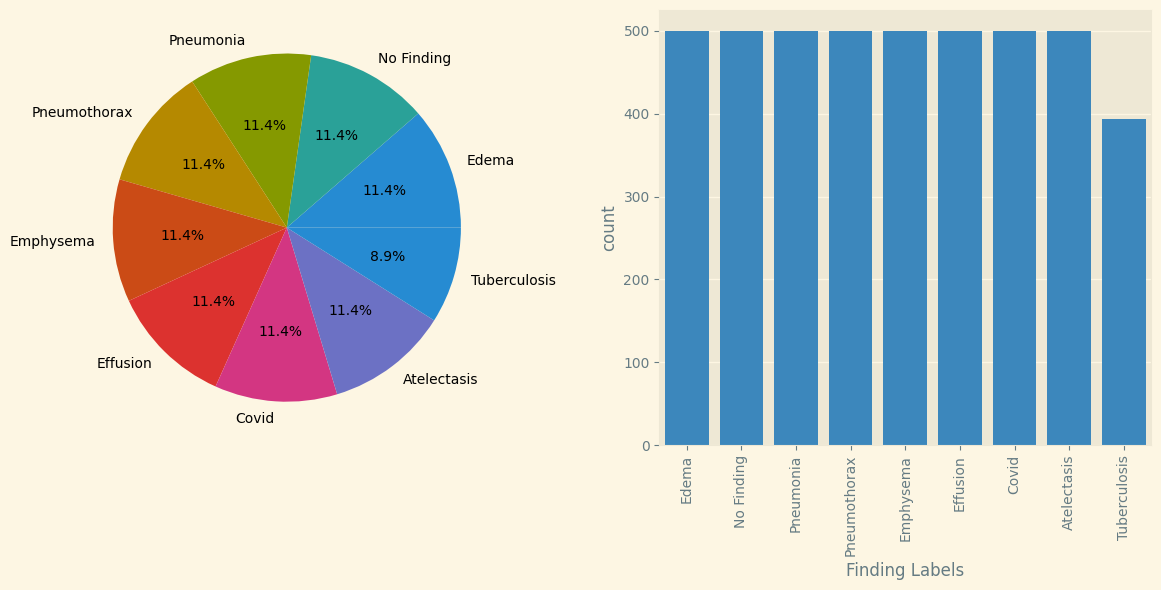

In [11]:
df = pd.read_csv('/content/rapid-cxr-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/content', '*','*','*', '*'))}

df['path'] = df['Image Index'].map(tmp)

label_counts = df['Finding Labels'].value_counts()
print(label_counts)

df_all = []

for label in ['Edema', 'No Finding', 'Pneumonia', 'Tuberculosis', 'Pneumothorax',  'Emphysema', 'Covid', 'Effusion', 'Atelectasis']:
    n = min(sample_num_setting, (df['Finding Labels'] == label).sum())
    df_all.append(df[df['Finding Labels'] == label].sample(n=n, random_state=42))

df = pd.concat(df_all)
df = df.reset_index(drop=True)

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'], order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**PA vs AP**

<Figure size 1200x600 with 0 Axes>

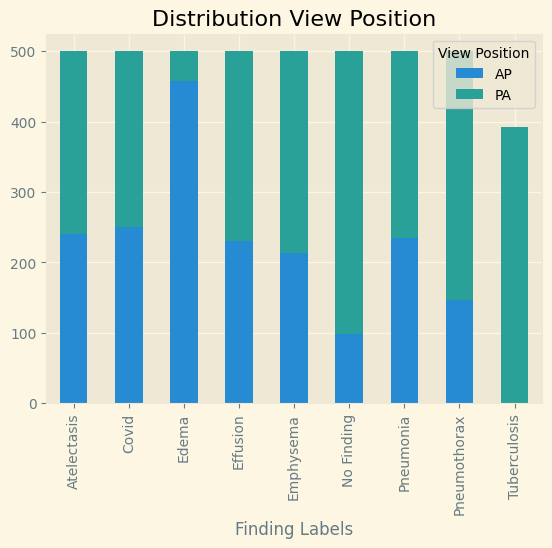

In [12]:
tmp = df.groupby(['Finding Labels','View Position']).size().unstack()
plt.figure(figsize=(12,6))
tmp.plot(kind='bar', stacked=True)
plt.title('Distribution View Position')
plt.show()

**Train & Test Split**

In [13]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

**One Hot Encoding**

In [14]:
for col in df['Finding Labels'].unique():
    df_test[col] = np.where(df_test['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
    df_train[col] = np.where(df_train['Finding Labels'].str.contains(col), 1.0, 0.0).astype('float32')
TARGET = df_train.columns[-9:].tolist()
TARGET

['Edema',
 'No Finding',
 'Pneumonia',
 'Tuberculosis',
 'Pneumothorax',
 'Emphysema',
 'Covid',
 'Effusion',
 'Atelectasis']

In [15]:
df_train.head()

,Image Index,Finding Labels,path,View Position,Patient ID,label_nunique,Edema,No Finding,Pneumonia,Tuberculosis,Pneumothorax,Emphysema,Covid,Effusion,Atelectasis
0,00012020_011.png,Pneumothorax,/content/rapid-cxr-dataset/lung_diseases/Pneum...,PA,12020,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,person368_virus_748.jpeg,Pneumonia,/content/rapid-cxr-dataset/lung_diseases/Pneum...,AP,p_3141,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00008041_000.png,No Finding,/content/rapid-cxr-dataset/lung_diseases/No Fi...,AP,8041,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,COVID19(435).jpg,Covid,/content/rapid-cxr-dataset/lung_diseases/Covid...,AP,c_363,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,CHNCXR_0656_1.png,Tuberculosis,/content/rapid-cxr-dataset/lung_diseases/Tuber...,PA,t_28,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


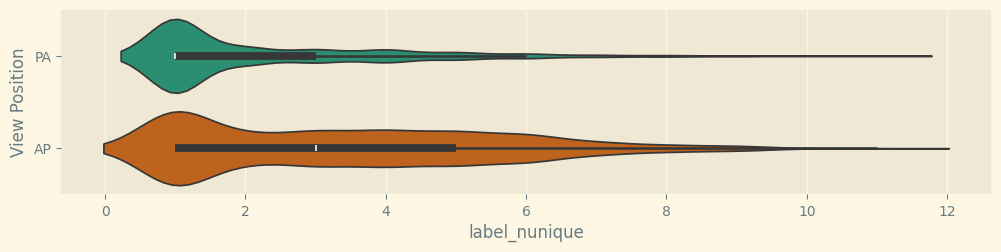

In [16]:
# @title View Position vs label_nunique

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_train['View Position'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_train, x='label_nunique', y='View Position', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Evaluation

In [43]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report

def comprehensive_model_evaluation(y_actual, y_predicted, TARGET):
    # 실제 클래스와 예측 클래스 생성
    y_true = np.argmax(y_actual, axis=1)
    y_pred = np.argmax(y_predicted, axis=1)

    # 1. Classification Report
    report = classification_report(y_true, y_pred, target_names=TARGET, output_dict=True)
    df_classification = pd.DataFrame(report).transpose()
    accuracy = report['accuracy']
    macro_f1 = report['macro avg']['f1-score']

    # Precision 및 Recall 그래프
    index = np.arange(len(TARGET))
    plt.figure(figsize=(12, 3))
    plt.bar(index - 0.2, df_classification['precision'][:-3], width=0.4, label='Precision', color='skyblue')
    plt.bar(index + 0.2, df_classification['recall'][:-3], width=0.4, label='Recall', color='lightgreen')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall by Class')
    plt.xticks(index, TARGET)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Precision-Recall Curve
    n_classes = y_actual.shape[1]
    ap_scores = []

    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_actual[:, i], y_predicted[:, i])
        ap = average_precision_score(y_actual[:, i], y_predicted[:, i])
        ap_scores.append(ap)
        plt.plot(recall, precision, lw=2, label=f'{TARGET[i]} (AP={ap:.2f})')

    mAP = np.mean(ap_scores)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.text(0.5, 0.02, f'mAP: {mAP:.4f}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()

    # 3. ROC Curve
    plt.figure(figsize=(10, 6))
    auc_scores = []
    for i, target in enumerate(TARGET):
        fpr, tpr, _ = roc_curve(y_actual[:, i], y_predicted[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores.append(roc_auc)
        plt.plot(fpr, tpr, label=f'{target} (AUC = {roc_auc:.2f})')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.plot([0, 1], [0, 1], 'r--')
    plt.tight_layout()
    plt.show()

    # 4. 결합된 데이터프레임 생성
    df_final = pd.DataFrame({
        'Class': TARGET,
        'Precision': df_classification['precision'][:-3],
        'Recall': df_classification['recall'][:-3],
        'F1-score': df_classification['f1-score'][:-3],
        'Support': df_classification['support'][:-3],
        'AP': ap_scores,
        'AUC': auc_scores
    })

    # 결과 출력
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
    print(f"Mean AUC: {np.mean(auc_scores):.4f}")

    return df_final, accuracy, macro_f1, mAP

def calculate_cel_ece(all_true, all_oof, n_bins=10):
    y_true = np.argmax(all_true, axis=1)
    y_pred = np.argmax(all_oof, axis=1)

    ce_loss = log_loss(y_true, all_oof)

    confidences = np.max(all_oof, axis=1)
    accuracies = (y_pred == y_true)

    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += (avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

    return ce_loss,ece

def visualize_loss_distribution(all_true, all_oof, TARGET):
    # 원핫 인코딩된 변수로 변환
    y_true = np.argmax(all_true, axis=1)
    y_pred = np.argmax(all_oof, axis=1)

    # 카테고리별 손실 계산
    loss = tf.keras.losses.categorical_crossentropy(all_true, all_oof)

    # 1. 레이블별 손실 분포 시각화
    plt.figure(figsize=(15, 3))
    plt.title('Distribution of Loss for Each Label')
    sns.boxplot(x=[TARGET[true_label] for true_label in y_true],
                y=loss.numpy(),
                order=TARGET)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 2. 레이블별 손실 통계 계산
    label_stats = pd.DataFrame({
        'Label': [TARGET[true_label] for true_label in y_true],
        'Loss': loss.numpy()
    }).groupby('Label')['Loss'].agg(['mean', 'std']).reindex(TARGET)
    label_stats.columns = ['Mean Loss', 'Std Dev']

    # 3. 레이블별 평균 손실 시각화
    plt.figure(figsize=(15, 3))
    plt.title('Mean Loss for Each Label')
    sns.barplot(x=label_stats.index, y='Mean Loss', data=label_stats, order=TARGET)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # # 4. 상위 5개 및 하위 5개 레이블 출력
    # print("\nTop 5 labels with highest mean loss:")
    # print(label_stats.sort_values('Mean Loss', ascending=False).head())

    # print("\nBottom 5 labels with lowest mean loss:")
    # print(label_stats.sort_values('Mean Loss', ascending=False).tail())

    return label_stats

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build DataGenerator</b></div>

In [18]:
import albumentations as albu
print(albu.__version__)

1.4.14


In [19]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, augment3 = False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.augment3 = augment3
        self.preprocess = preprocess
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        if self.augment3: X = self.__augment3(X)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.zeros((len(indexes), 256, 256, 3), dtype='float32')
        y = np.zeros((len(indexes), len(TARGET)), dtype='float32')

        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = Image.open(path).convert('L')
            img = img.resize((256, 256), Image.Resampling.LANCZOS)
            img = np.array(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            X[j, :, :] = img
            y[j,] = row[TARGET]

        return X, y

    def __augment1(self, img_batch):

        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),

        ])

        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img

        return img_batch


    def __augment2(self, img_batch, mixup_prob=0.1):
        batch_size, height, width, channels = img_batch.shape

        idx = np.random.permutation(batch_size)
        lam = np.random.beta(2.0, 2.0)

        for i in range(batch_size):
            if np.random.rand() <= mixup_prob:
                j = idx[i]

                img_batch[i] = img_batch[i] * lam + img_batch[j] * (1-lam)

        return img_batch

    def __augment3(self, img_batch):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            albu.RandomRotate90(p=0.5),
          #  albu.RandomBrightnessContrast(p=0.5),
          #  albu.HueSaturationValue(p=1, hue_shift_limit=1),
            albu.GaussianBlur(blur_limit=(3, 7), p=0.3),
          #  albu.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            albu.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.3),
            albu.Rotate(limit=45, p=0.5),
            albu.Resize(256, 256, always_apply=True)  # 항상 256x256으로 다시 조정
        ])

        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img

        return img_batch

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build ResNet Model</b></div>

In [20]:
!pip install -q git+https://github.com/qubvel/classification_models.git


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00


**Install ResNet**

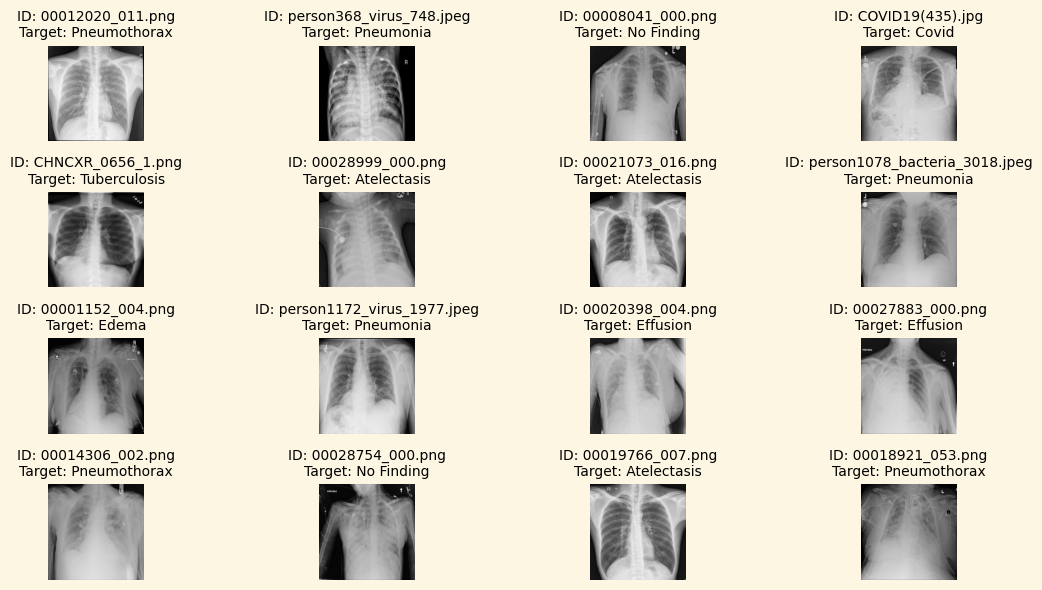

In [21]:
from classification_models.tfkeras import Classifiers

resnet18, preprocess_input = Classifiers.get('resnet18')

ROWS = 4; COLS = 4; BATCHES = 1

gen = DataGenerator(df_train, batch_size=16, shuffle=True, augment1=True, augment2=False, augment3=False, preprocess=preprocess_input)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

#### Macro F1_Score

In [22]:
def f1_score(y_true, y_pred):
    # Calculate the F1 score for each class
    f1_scores = []
    num_classes = K.int_shape(y_pred)[-1]  # (batch_size, output_dims = num_classes)

    # Get the true and predicted class indices
    y_true = K.argmax(y_true, axis=-1)
    y_pred = K.argmax(y_pred, axis=-1) # For Label Smoothing(in CCE)

    for i in range(num_classes):
        true_positives = K.sum(K.cast(tf.logical_and(K.equal(y_true, i), K.equal(y_pred, i)), dtype=tf.float32))
        possible_positives = K.sum(K.cast(K.equal(y_true, i), dtype=tf.float32))
        predicted_positives = K.sum(K.cast(K.equal(y_pred, i), dtype=tf.float32))

        recall = true_positives / (possible_positives + K.epsilon())
        precision = true_positives / (predicted_positives + K.epsilon())

        f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
        f1_scores.append(f1_score)

    # Calculate the macro-average F1 score
    macro_f1_score = K.mean(tf.stack(f1_scores))
    return macro_f1_score

**ReduceLROnPleateau in Callbacks**

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

EPOCHS = epoch_setting

lr = ReduceLROnPlateau(monitor = 'val_f1_score', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [30]:
def build_model():
    inp = tf.keras.layers.Input(shape=(256,256,3))
    res_model = resnet18(include_top=False, weights='imagenet', input_shape=(256,256,3))
    res_model._name = 'resnet18'

    ## Freezing Layer(10% Layer)
    for layer in res_model.layers[:len(res_model.layers)//10]:
        layer.trainable = False

    x = res_model(inp)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(len(TARGET), activation='softmax', dtype='float32')(x)

    # Compile
    model = tf.keras.Model(inputs=inp, outputs=x, name='hybrid')

    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing_setting)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_setting)

    model.compile(loss=loss, optimizer=opt, metrics=['accuracy', f1_score])

    return model

In [31]:
from tensorflow.keras.utils import plot_model

model = build_model()
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

Model: "hybrid"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 8, 8, 512)           │      11,186,889 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,191,506 (42.69 MB)

 Trainable params: 11,174,025 (42.63 MB)

 Non-trainable params: 17,481 (68.29 KB)

#### StratifiedKFold

In [26]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (_, valid_index) in enumerate(skf.split(df_train, df_train['Finding Labels'])):
    df_train.loc[valid_index, 'Fold'] = i

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. TRAIN</b></div>

In [32]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(fold_num_setting): # Fold는 1개만

    print('#'*25)
    print(f'### Fold {i+1}')

    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=False, augment3=False, batch_size=train_batch_setting, preprocess=preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=valid_batch_setting, preprocess=preprocess_input)

    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)

    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid F1'].append(history.history['val_f1_score'])
        all_history['Train F1'].append(history.history['f1_score'])
        all_history['Valid Accuracy'].append(history.history['val_accuracy'])
        all_history['Train Accuracy'].append(history.history['accuracy'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')

    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['path'].values)

    del model, oof, train_gen, valid_gen
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 2811, valid size 703
#########################
Epoch 1/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 123s 630ms/step - accuracy: 0.2536 - f1_score: 0.1846 - loss: 2.3147 - val_accuracy: 0.1565 - val_f1_score: 0.0911 - val_loss: 13.8640 - learning_rate: 0.0030
Epoch 2/2
176/176 ━━━━━━━━━━━━━━━━━━━━ 113s 618ms/step - accuracy: 0.3739 - f1_score: 0.2874 - loss: 1.8916 - val_accuracy: 0.1991 - val_f1_score: 0.1254 - val_loss: 7.0813 - learning_rate: 0.0030
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 959ms/step


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>6. TRAIN-RESULT</b></div>

#### 1. 지표

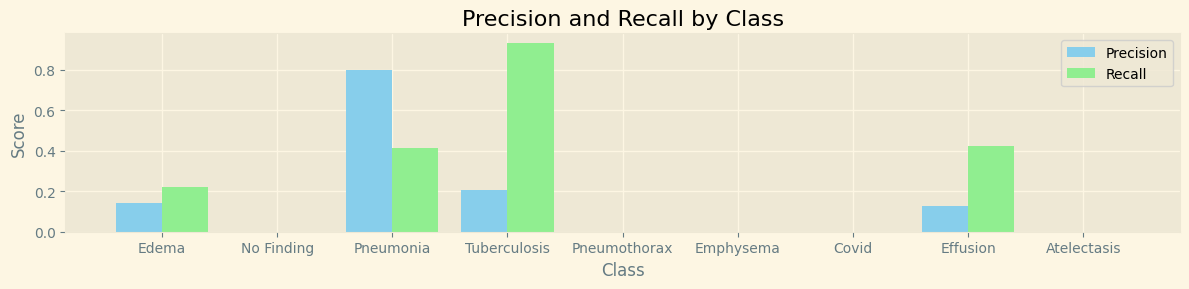

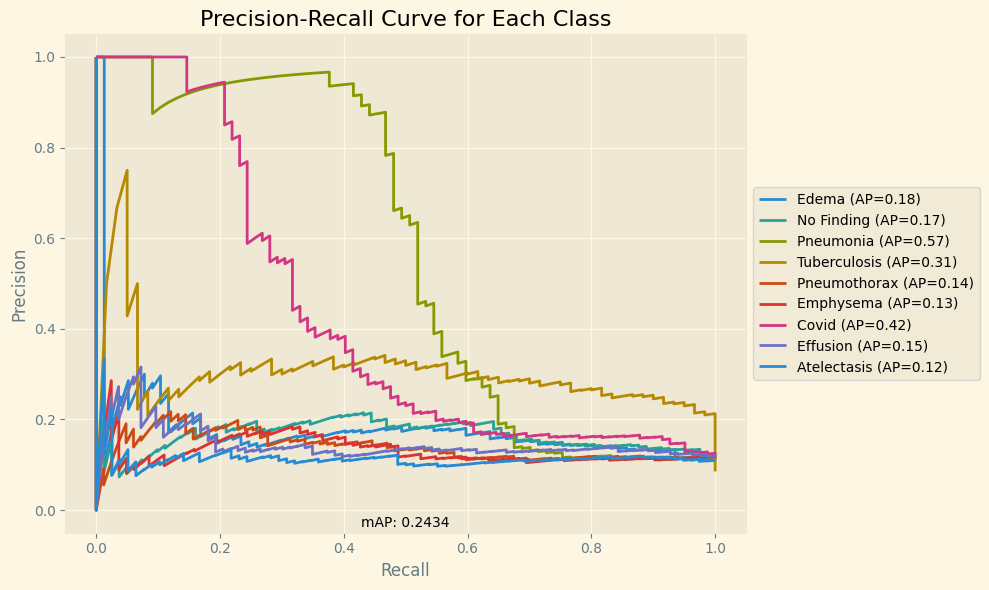

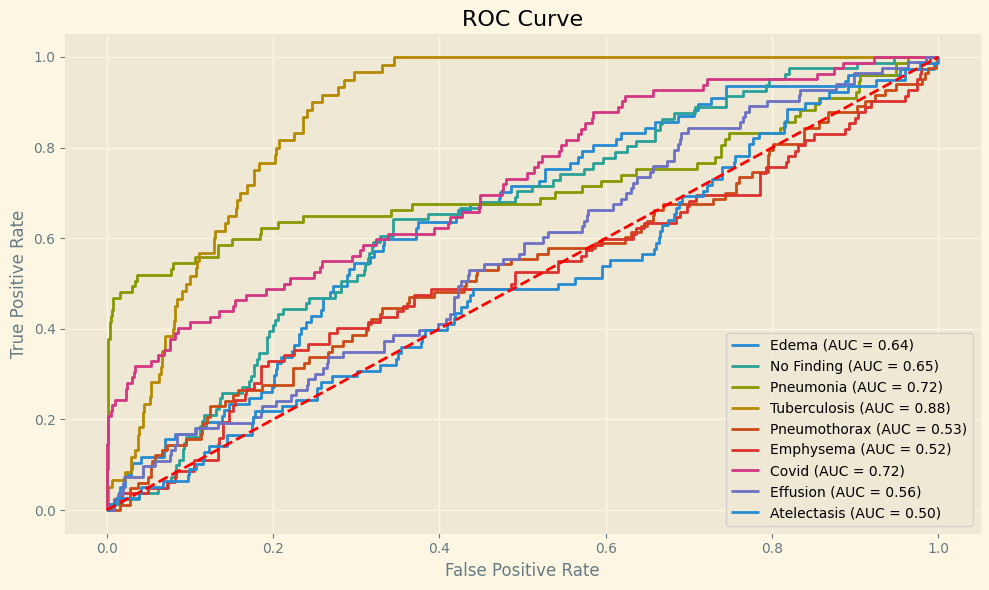


Accuracy: 0.1991
Macro F1 Score: 0.1394
Mean Average Precision (mAP): 0.2434
Mean AUC: 0.6344
Train Accuracy: 0.199
Train f1 score: 0.139


,Class,Precision,Recall,F1-score,Support,AP,AUC
Edema,Edema,0.141667,0.220779,0.172589,77.0,0.180607,0.644309
No Finding,No Finding,0.000000,0.000000,0.000000,81.0,0.166745,0.649240
Pneumonia,Pneumonia,0.800000,0.415584,0.547009,77.0,0.566896,0.717584
Tuberculosis,Tuberculosis,0.205882,0.933333,0.337349,60.0,0.311973,0.876672
Pneumothorax,Pneumothorax,0.000000,0.000000,0.000000,83.0,0.141827,0.529732
Emphysema,Emphysema,0.000000,0.000000,0.000000,82.0,0.133577,0.515651
Covid,Covid,0.000000,0.000000,0.000000,82.0,0.423360,0.719748
Effusion,Effusion,0.129151,0.421687,0.197740,83.0,0.148930,0.558881
Atelectasis,Atelectasis,0.000000,0.000000,0.000000,78.0,0.116741,0.497805


In [36]:
# 지표 1
result_train, train_accuracy, train_f1, mAP= comprehensive_model_evaluation(all_true, all_oof, TARGET)
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Train f1 score: {train_f1:.3f}')
result_train

#### 2. Confusion Matrix

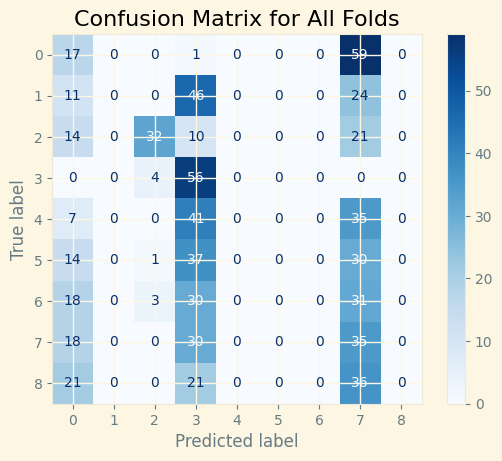

array([[17,  0,  0,  1,  0,  0,  0, 59,  0],
       [11,  0,  0, 46,  0,  0,  0, 24,  0],
       [14,  0, 32, 10,  0,  0,  0, 21,  0],
       [ 0,  0,  4, 56,  0,  0,  0,  0,  0],
       [ 7,  0,  0, 41,  0,  0,  0, 35,  0],
       [14,  0,  1, 37,  0,  0,  0, 30,  0],
       [18,  0,  3, 30,  0,  0,  0, 31,  0],
       [18,  0,  0, 30,  0,  0,  0, 35,  0],
       [21,  0,  0, 21,  0,  0,  0, 36,  0]])

In [37]:
#  모든 폴드의 데이터를 합친 전체 confusion matrix도 생성합니다.
train_cm = confusion_matrix(np.argmax(all_true, axis=1),
                          np.argmax(all_oof, axis=1),
                          labels=[x for x in range(len(TARGET))])

disp_all = ConfusionMatrixDisplay(confusion_matrix=train_cm,
                                  display_labels=[x for x in range(len(TARGET))])
disp_all.plot(cmap='Blues')
plt.title('Confusion Matrix for All Folds')
plt.show()
train_cm

#### 3. Train & Valid | Loss & F1 & Accuracy

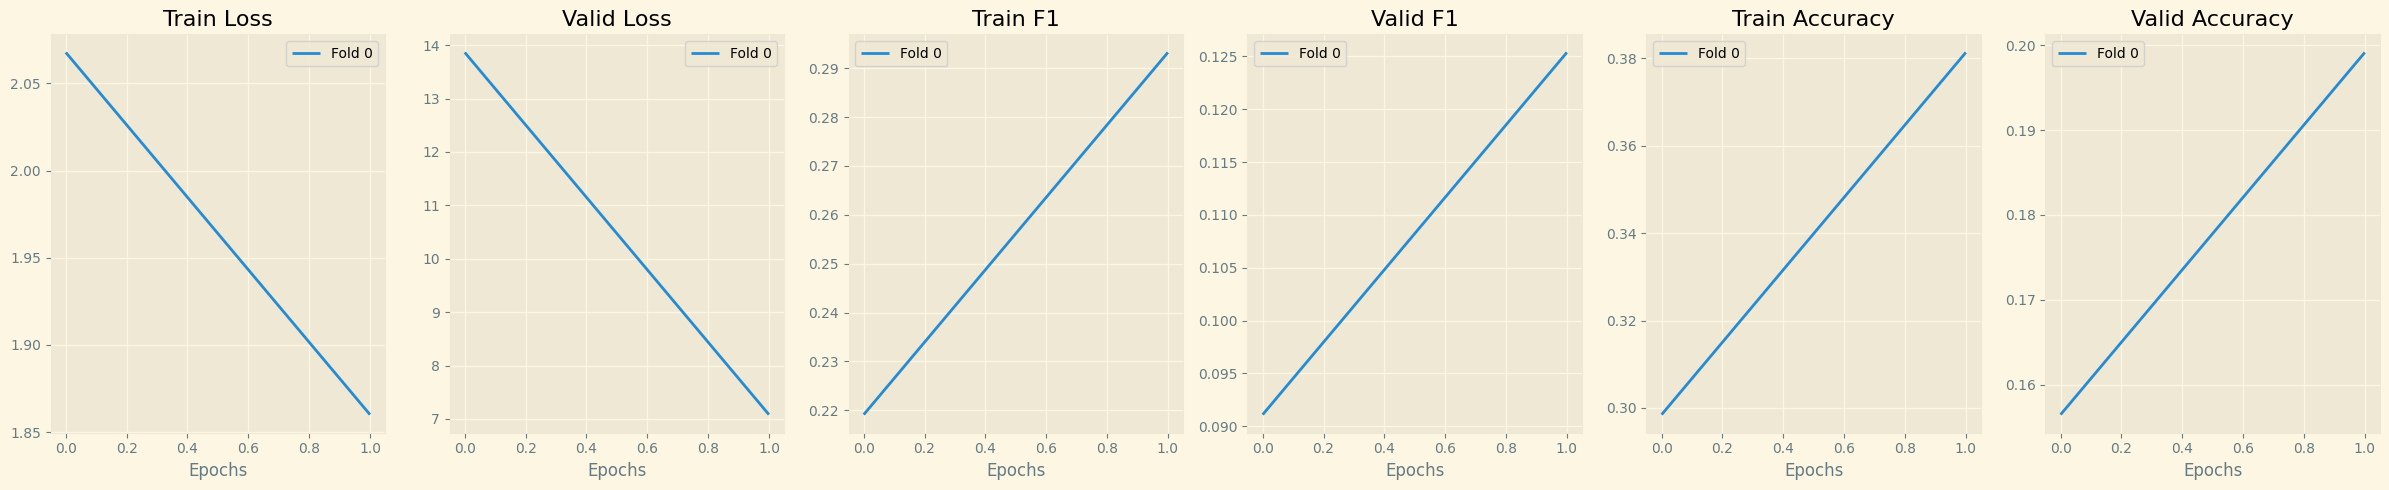

,Train Loss,Valid Loss,Valid F1,Train F1,Valid Accuracy,Train Accuracy
Fold,,,,,,
0,"[2.068, 1.860]","[13.864, 7.081]","[0.091, 0.125]","[0.219, 0.293]","[0.156, 0.199]","[0.298, 0.381]"


In [38]:
## Train & Valid | Loss & F1 & Accuracy
if LOAD_MODELS_FROM is None:
	plt.figure(figsize=(24,5))

	metrics = ['Train Loss', 'Valid Loss', 'Train F1', 'Valid F1', 'Train Accuracy', 'Valid Accuracy']

	for idx, metric in enumerate(metrics, 1):
		plt.subplot(1, 6, idx)
		plt.title(metric)
		for fold, i in enumerate(all_history[metric]):
			plt.plot(i, label=f'Fold {fold}')
		plt.xlabel('Epochs')
		plt.legend()

	plt.tight_layout()
	plt.show()
history_train_df = pd.DataFrame(all_history)
history_train_df.index.name = 'Fold'
history_train_df = history_train_df.applymap(lambda x: [f'{i:.3f}' for i in x] if isinstance(x, list) else x)
history_train_df

#### 4. CEE | ECE

#### TRAIN CEE and ECE
Cross-entropy loss: 5.5721
Expected Calibration Error: 0.4603


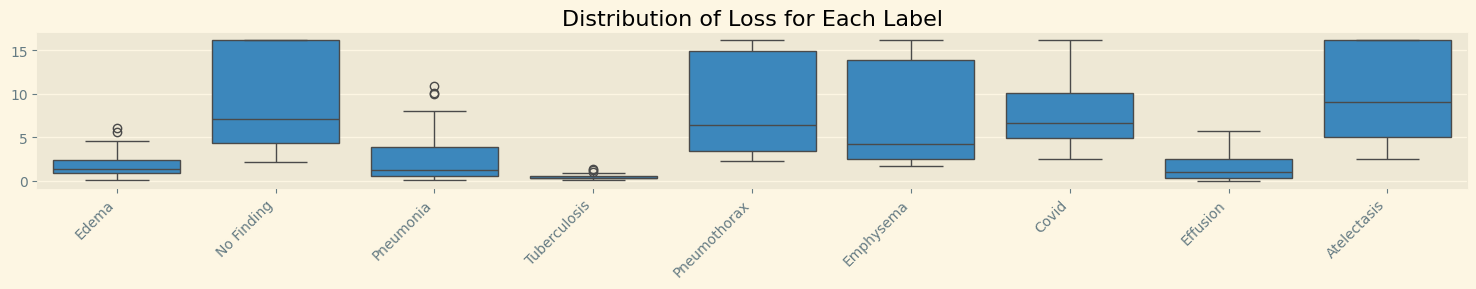

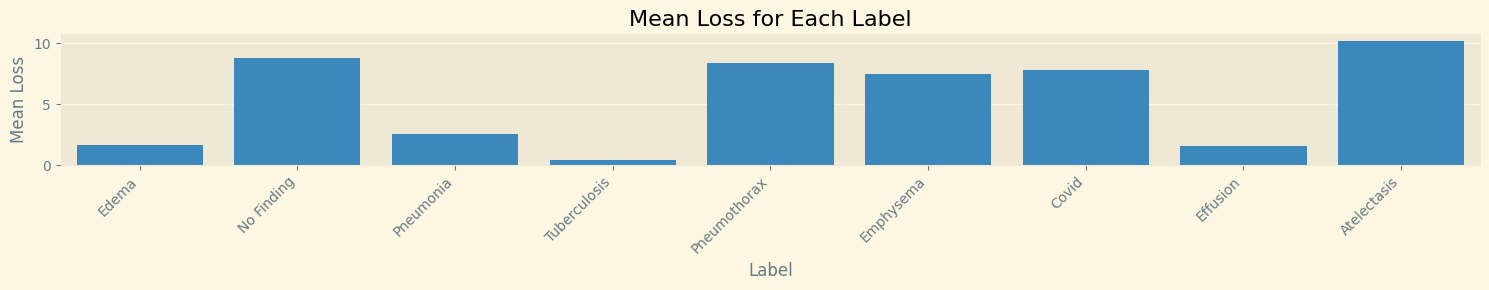

,Mean Loss,Std Dev
Label,,
Edema,1.682477,1.208955
No Finding,8.738441,4.990357
Pneumonia,2.531137,2.762381
Tuberculosis,0.438403,0.247480
Pneumothorax,8.395304,5.379515
Emphysema,7.490253,5.743242
Covid,7.777484,3.821489
Effusion,1.552147,1.489487
Atelectasis,10.207150,5.366200


In [44]:
### CEE | ECE

train_CEE,train_ECE = calculate_cel_ece(all_true, all_oof)

print('#### TRAIN CEE and ECE')
print(f"Cross-entropy loss: {train_CEE:.4f}\nExpected Calibration Error: {train_ECE:.4f}")

# 7 손실 분포
train_loss_stats = visualize_loss_distribution(all_true, all_oof, TARGET)
train_loss_stats

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>7. TEST</b></div>

In [45]:
preds = []
model = build_model()

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=test_batch_setting, preprocess=preprocess_input)

for i in range(fold_num_setting):
	print(f'Fold {i+1}')
	if LOAD_MODELS_FROM:
		model.load_weights(f'{LOAD_MODELS_FROM}ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')
	else:
		model.load_weights(f'ResNet_{str(learning_rate_setting)}_f{i}.weights.h5')


	pred = model.predict(test_gen, verbose=1)
	preds.append(pred)
pred_res = np.mean(preds,axis=0)

Fold 1
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>8. TEST-RESULT</b></div>

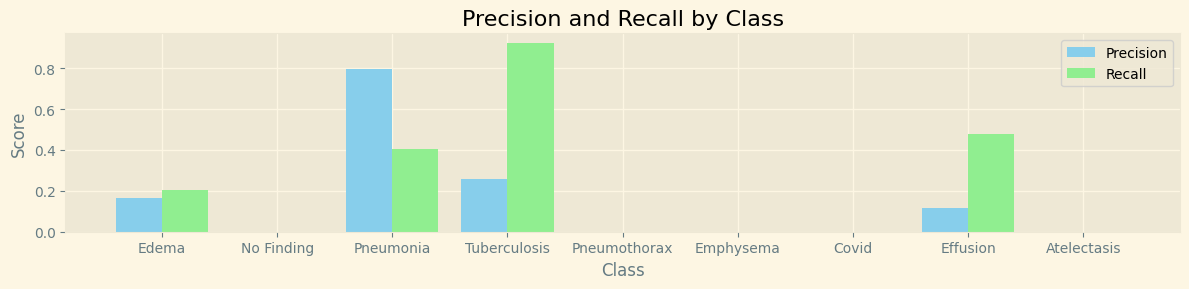

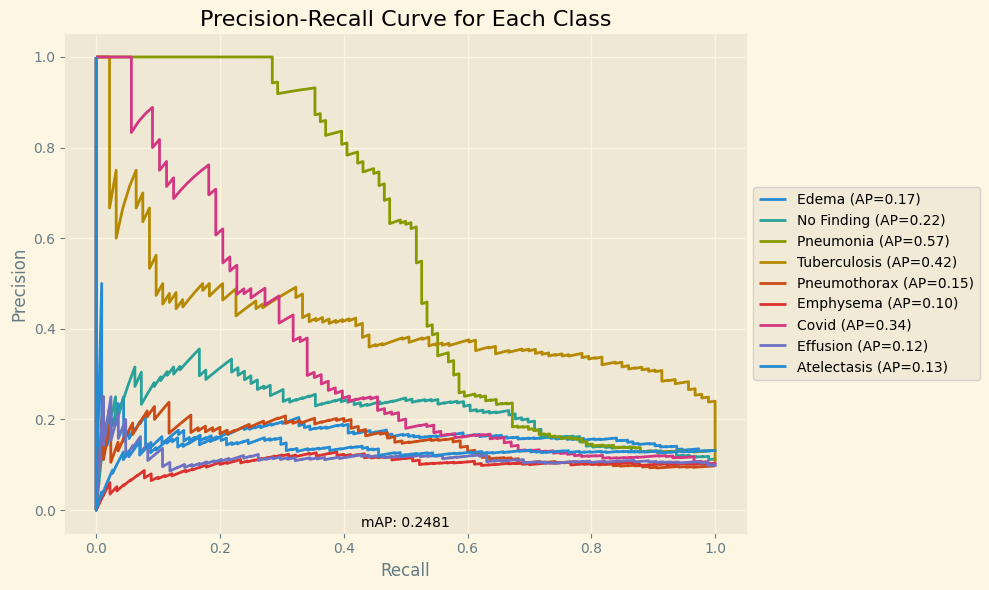

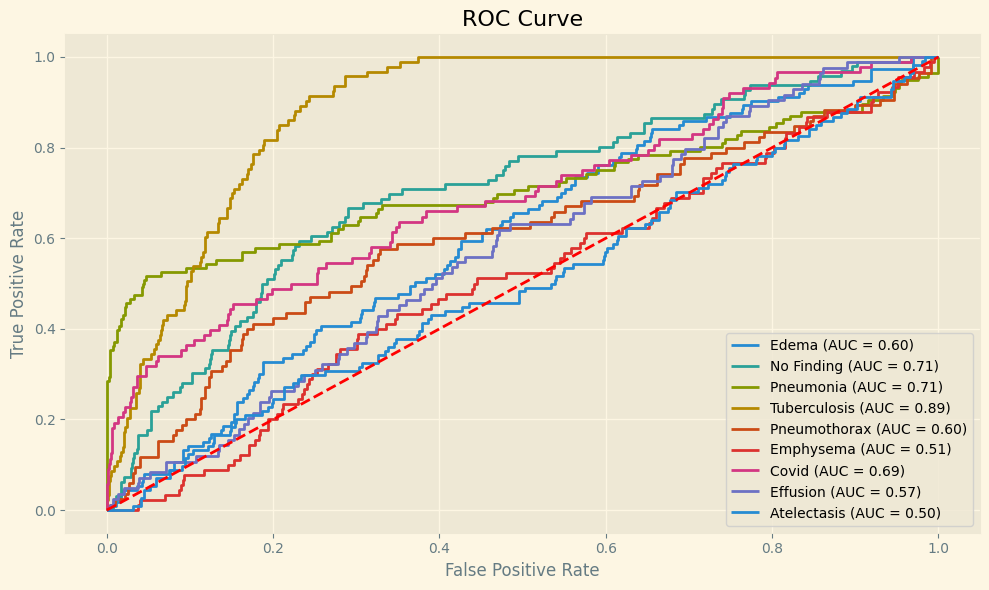


Accuracy: 0.2230
Macro F1 Score: 0.1455
Mean Average Precision (mAP): 0.2481
Mean AUC: 0.6427
Test Accuracy: 0.223
Test f1 score: 0.146


,Class,Precision,Recall,F1-score,Support,AP,AUC
Edema,Edema,0.163121,0.203540,0.181102,113.0,0.170627,0.603861
No Finding,No Finding,0.000000,0.000000,0.000000,96.0,0.223371,0.705965
Pneumonia,Pneumonia,0.796610,0.405172,0.537143,116.0,0.567665,0.710478
Tuberculosis,Tuberculosis,0.258258,0.924731,0.403756,93.0,0.420177,0.886727
Pneumothorax,Pneumothorax,0.000000,0.000000,0.000000,85.0,0.152944,0.604801
Emphysema,Emphysema,0.000000,0.000000,0.000000,90.0,0.102855,0.509168
Covid,Covid,0.000000,0.000000,0.000000,88.0,0.342344,0.688585
Effusion,Effusion,0.116959,0.476190,0.187793,84.0,0.119402,0.572447
Atelectasis,Atelectasis,0.000000,0.000000,0.000000,114.0,0.133518,0.502179


In [46]:
# 지표 1
result_test, test_accuracy, test_f1, mAP= comprehensive_model_evaluation(df_test[TARGET].values, pred_res, TARGET)
print(f'Test Accuracy: {test_accuracy:.3f}')
print(f'Test f1 score: {test_f1:.3f}')
result_test

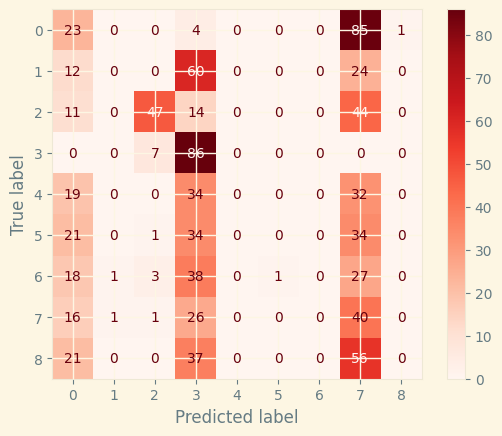

array([[23,  0,  0,  4,  0,  0,  0, 85,  1],
       [12,  0,  0, 60,  0,  0,  0, 24,  0],
       [11,  0, 47, 14,  0,  0,  0, 44,  0],
       [ 0,  0,  7, 86,  0,  0,  0,  0,  0],
       [19,  0,  0, 34,  0,  0,  0, 32,  0],
       [21,  0,  1, 34,  0,  0,  0, 34,  0],
       [18,  1,  3, 38,  0,  1,  0, 27,  0],
       [16,  1,  1, 26,  0,  0,  0, 40,  0],
       [21,  0,  0, 37,  0,  0,  0, 56,  0]])

In [49]:
# 지표3 Confusion Matrix
cm_test = confusion_matrix(np.argmax(df_test[TARGET].values, axis=1), np.argmax(pred_res, axis=1), labels=[x for x in range(len(TARGET))])
display = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[x for x in range(len(TARGET))])
display.plot(cmap='Reds')

plt.show()
cm_test

지표4 패스

#### TEST CEE and ECE
Cross-Entropy Error(CEE): 5.1599
Expected Calibration Error(ECE): 0.4344
Loss distribution for TEST


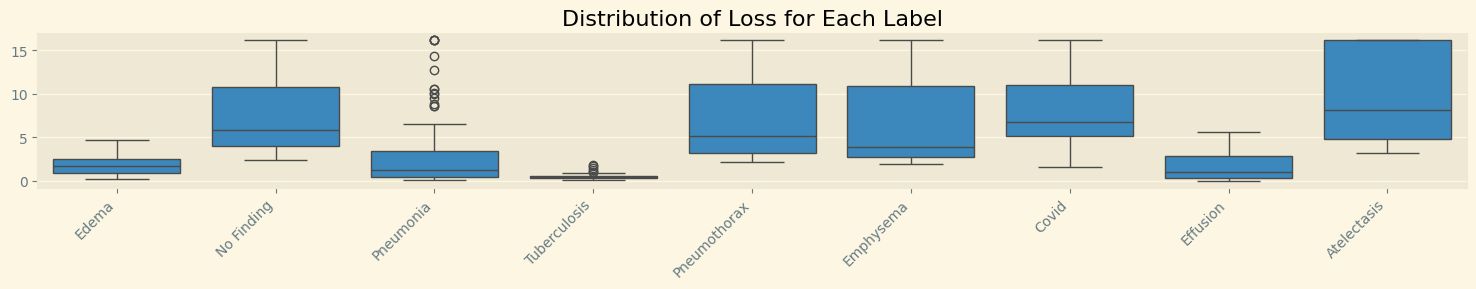

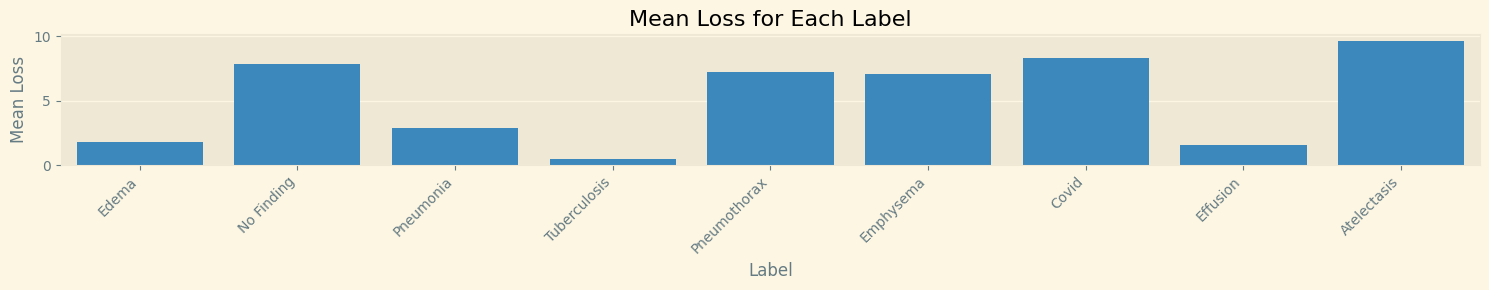

,Mean Loss,Std Dev
Label,,
Edema,1.798410,1.081449
No Finding,7.830212,4.805808
Pneumonia,2.896516,3.870692
Tuberculosis,0.455301,0.311336
Pneumothorax,7.231234,5.097734
Emphysema,7.073268,5.394475
Covid,8.351985,4.453506
Effusion,1.562691,1.529478
Atelectasis,9.673202,5.076129


In [50]:
# 6. Cross-Entropy Error | Expected Calibration Error
test_CEE, test_ECE = calculate_cel_ece(df_test[TARGET].values, pred_res)

print('#### TEST CEE and ECE')
print(f"Cross-Entropy Error(CEE): {test_CEE:.4f}")
print(f"Expected Calibration Error(ECE): {test_ECE:.4f}")

# 7. 손실 분포
print('Loss distribution for TEST')
visualize_loss_distribution(df_test[TARGET].values, pred_res, TARGET)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>9. Overall Result</b></div>

In [51]:
print(f'LEARNING RATE: {learning_rate_setting}')
print()

print(f'train_accuracy: {train_accuracy:.4f}')
print(f'train_f1: {train_f1:.4f}')
print(f'test_accuracy: {test_accuracy:.4f}')
print(f'test f1: {test_f1:.4f}')

print()
print(f'mAP: {mAP:.4f}')

print()
print(f'train CEE: {train_CEE:.4f}')
print(f'train ECE: {train_ECE:.4f}')
print(f'test CEE: {test_CEE:.4f}')
print(f'test_ECE: {test_ECE:.4f}')


print(f'\n{test_accuracy:.4f} | {test_f1:.4f} | {test_CEE:.4f} | {test_ECE:.4f} | {train_accuracy:.4f} | {train_f1:.4f} | {train_CEE:.4f} | {train_ECE:.4f}')


LEARNING RATE: 0.003

train_accuracy: 0.1991
train_f1: 0.1394
test_accuracy: 0.2230
test f1: 0.1455

mAP: 0.2481

train CEE: 5.5721
train ECE: 0.4603
test CEE: 5.1599
test_ECE: 0.4344

0.2230 | 0.1455 | 5.1599 | 0.4344 | 0.1991 | 0.1394 | 5.5721 | 0.4603


In [55]:
from datetime import datetime

print(*TARGET,sep=', ')
print()
for i,x in experiment_setting.items():
    print(f'{i}: {x}')

print()

current_time = datetime.now()
print(f'완료 시간: {current_time.strftime("%Y-%m-%d %H:%M:%S")}')

Edema, No Finding, Pneumonia, Tuberculosis, Pneumothorax, Emphysema, Covid, Effusion, Atelectasis

sample_num_setting: 500
epoch_setting: 2
label_smoothing_setting: 0.15
learning_rate_setting: 0.003
train_batch_setting: 16
valid_batch_setting: 32
test_batch_setting: 64
fold_num_setting: 1

완료 시간: 2024-09-04 06:08:13
